## makemore - MLP v2, closer look

This implementation includes:
- Uniform initial loss 
- Multiple layers
- Diagnostics and visualizations
- BatchNorm

Below: Initialization of dataset

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import random
import numpy as np

names = open('data/names.txt', 'r').read().splitlines()
print("Sample names: ", names[5:12])
print("Number of names: ", len(names))

# create char to index mapping for set (vocabulary) of chars in names
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print("Character mapping: ", itos)
print("Vocab Size: ", vocab_size)

Sample names:  ['charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily']
Number of names:  32033
Character mapping:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab Size:  27


In [2]:
# building dataset
context_length = 3 

def build_dataset(names):
    X, Y = [], []
    for name in names:

        context = [0] * context_length 
        for char in name + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

random.seed(1337)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtrain, Ytrain = build_dataset(names[:n1])  # 80%
Xval, Yval = build_dataset(names[n1:n2])    # 10%
Xtest, Ytest = build_dataset(names[n2:])    # 10%

torch.Size([182594, 3]) torch.Size([182594])
torch.Size([22690, 3]) torch.Size([22690])
torch.Size([22864, 3]) torch.Size([22864])


End: initialization of dataset

Begin: MLP definition

In [19]:
# kaiming init
# std = gain / sqrt(fan_in) for tanh 
(5/3) / (np.sqrt(10 * context_length)) # fan_in is 30; 10 dimensions * 3 characters

# gets to ~ the same validation loss, but no random numbers in weights initialization

np.float64(0.3042903097250923)

In [29]:
# constructing network 

dim_embed = 10
hidden_layer_size = 200

g = torch.Generator().manual_seed(978467474)
C = torch.randn((vocab_size, dim_embed),                            generator=g)
# hidden layer
W1 = torch.randn((dim_embed * context_length, hidden_layer_size),   generator=g) * (5/3) / (np.sqrt(dim_embed * context_length)) #* 0.2 
# b1 = torch.randn(hidden_layer_size,                                 generator=g) * 0.02 # non-zero for entropy (removed in favor of batchnorm)
# output layer
W2 = torch.randn((hidden_layer_size, vocab_size),                   generator=g) * 0.01 # initialize small but not 0, so that symmetry is broken
b2 = torch.randn(vocab_size,                                        generator=g) * 0 # initialize with zeros; between this and above, gives near uniform initial probabilities

# batchnorm
bngain = torch.ones((1, hidden_layer_size))
bnbias = torch.zeros((1, hidden_layer_size))
bnmean_running = torch.zeros((1, hidden_layer_size))
bnstd_running = torch.ones((1, hidden_layer_size))


parameters = [C, W1, W2, b2, bngain, bnbias] # all parameters of the model (b1 removed)
print(sum(p.nelement() for p in parameters)) # number of parameters in the model
for p in parameters:
    p.requires_grad = True

12097


In [30]:
# training loop

def train(steps, lr, batch_size=32):
    batch_losses = []  # added here to capture loss later when we scale up neuron count
    for _ in range(steps):

        # batch
        ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
        Xb, Yb = Xtrain[ix], Ytrain[ix]

        # forward pass 
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

        # linear layer
        hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation


        # batch norm layer
        bnmeani = hpreact.mean(0, keepdim=True)
        bnstdi = hpreact.std(0, keepdim=True)

        hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias # batch norm step
        
        with torch.no_grad(): # update running estimates
            bnmean_running.mul_(0.999).add_(bnmeani, alpha=0.001)
            bnstd_running.mul_(0.999).add_(bnstdi, alpha=0.001)

        # nonlinearity

        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        for p in parameters:
            p.data += p.grad * -lr  # in-place, safe under no_grad

        batch_losses.append(loss.item())
    return batch_losses

    # print(loss.item()) # loss per batch 

# whole-dataset evaluation helper 
"""@torch.no_grad() # decorator that disables gradient tracking
def evaluate(X, Y):
    emb = C[X] 
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1 
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y) 
    return loss.item()"""

# split evaluation helper 
@torch.no_grad()
def split_evaluate(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'val': (Xval, Yval),
        'test': (Xtest, Ytest)
    }[split]

    emb = C[x] 
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 #+ b1

    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias # batch norm step
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y) 
    return loss.item()


In [31]:
# training

# track training loss
train_loss = []     # per epoch now
val_loss = []       # per epoch

# training parameters
epochs = 200
steps_per_epoch = 1000
learning_rate = 0.1

for epoch in range (epochs): 
    if epoch == 80: learning_rate = 0.04 # hacky learning rate decay
    if epoch == 150: learning_rate = 0.01 # hacky learning rate decay

    train(steps_per_epoch, learning_rate, batch_size=32) 
    train_loss.append(split_evaluate('train')) # capture train loss at epoch end rather than mini-batch loss
    val_loss.append(split_evaluate('val'))

    if epoch % 20 == 0: print(f"Epoch {epoch}: val loss {val_loss[-1]}")

Epoch 0: val loss 2.472517251968384
Epoch 20: val loss 2.253559112548828
Epoch 40: val loss 2.22529935836792
Epoch 60: val loss 2.214064836502075
Epoch 80: val loss 2.1625473499298096
Epoch 100: val loss 2.156155586242676
Epoch 120: val loss 2.154899835586548
Epoch 140: val loss 2.1573705673217773
Epoch 160: val loss 2.1317086219787598
Epoch 180: val loss 2.132432699203491


=== Loss summary ===
Train — last: 2.0669  (epoch 200)
Train —  min:  2.0669  (epoch 199)
Val   — last: 2.1310     (epoch 200)
Val   —  min:  2.1283     (epoch 197)


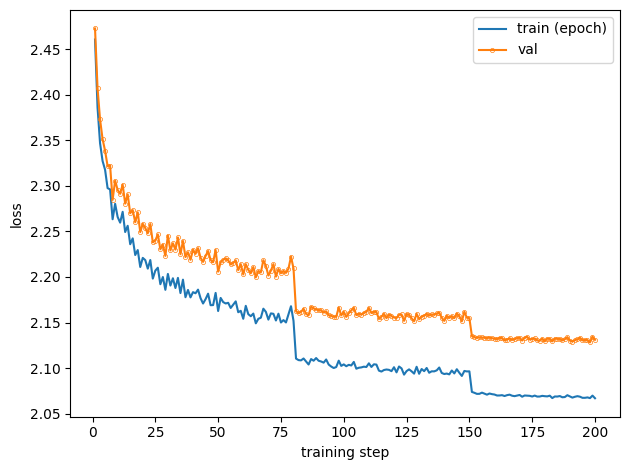

In [32]:
# showing training results

# optimizations:
#    initial loss is closer to final after initializing w2 and b2 to small values
#    small values rather than 0, to add entropy and prevent dead neurons/tanh saturation
#    kaiming init: mathematical approach to setting those small entropy values

E = len (train_loss)      # number of epochs
xs = np.arange(1, E+1)


# --- plot (epoch-level curves) ---
plt.figure()
plt.plot(xs, train_loss, label='train (epoch)')
plt.plot(xs, val_loss, marker='o', ms=3, mew=0.5, mfc='none', mec='auto', label='val')
plt.xlabel('training step'); plt.ylabel('loss'); plt.legend(); plt.tight_layout()


ti = int(np.argmin(train_loss))   # index of min train loss (epoch-level)
vi = int(np.argmin(val_loss))     # index of min val loss (epoch-level)

print("=== Loss summary ===")
print(f"Train — last: {train_loss[-1]:.4f}  (epoch {E})")
print(f"Train —  min:  {train_loss[ti]:.4f}  (epoch {ti})")

print(f"Val   — last: {val_loss[-1]:.4f}     (epoch {E})")
print(f"Val   —  min:  {val_loss[vi]:.4f}     (epoch {vi})")


In [34]:
# batchnorm; estimating and fixing mean and std for inference 
# replaced in favor of taking this into account during training
"""with torch.no_grad():
  # pass training set through
  emb = C[Xtrain]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  batchnorm_mean = hpreact.mean(0, keepdim=True)
  batchnorm_std = hpreact.std(0, keepdim=True)"""

'with torch.no_grad():\n  # pass training set through\n  emb = C[Xtrain]\n  embcat = emb.view(emb.shape[0], -1)\n  hpreact = embcat @ W1 + b1\n  batchnorm_mean = hpreact.mean(0, keepdim=True)\n  batchnorm_std = hpreact.std(0, keepdim=True)'

In [36]:
# sample from the model
"""for _ in range(20):
    
    out = []
    context = [0] * context_length # initializes with all '.' chars 
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() # sample
      context = context[1:] + [ix] # slide window
      out.append(ix)
      if ix == 0: # break on end token '.'
        break
    
    print(''.join(itos[i] for i in out))"""


# batchnorm version, calibrate batch norm at the end of training and incorporate into hpreact

for _ in range(20):
    
    out = []
    context = [0] * context_length # initializes with all '.' chars 
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh((emb.view(1, -1) @ W1 - bnmean_running) / bnstd_running)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() # sample
      context = context[1:] + [ix] # slide window
      out.append(ix)
      if ix == 0: # break on end token '.'
        break
    
    print(''.join(itos[i] for i in out))


liyaon.
bekayze.
jakjynzegaryelizamareydeshaajenzreisya.
iveytavaniestashlas.
theya.
ahiypren.
xabharrotta.
pruxefyan.
sayconteesiant.
yuhamaddei.
rerroirenyah.
ammagga.
zyiah.
jameaisla.
rhystas.
zii.
blaurn.
zochi.
dee.
tyr.


### Optimizations

#### Expected loss at initialization

In [67]:
-torch.tensor(1/vocab_size).log().item() # expected loss of uniform distribution (each char equally likely to be next)

# set b2 and W2 lower to get near uniform initial probabilities on logits -> achieve near expected loss at initialization

3.295836925506592

#### Saturated tanh at initialization

h shape:  torch.Size([32, 200])


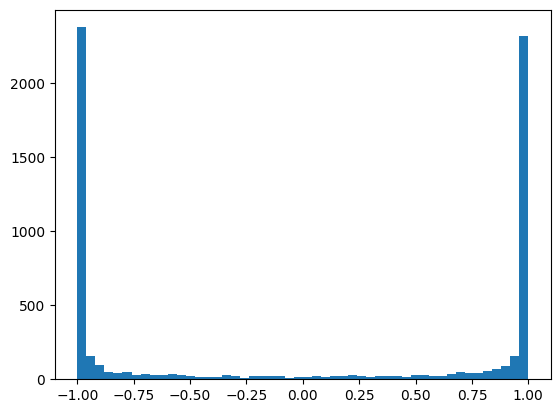

In [ ]:
# recreate h for inspection

dim_embed = 10
hidden_layer_size = 200
context_length = 3

g = torch.Generator().manual_seed(978467474)
C = torch.randn((vocab_size, dim_embed),                            generator=g)
W1 = torch.randn((dim_embed * context_length, hidden_layer_size),   generator=g) 
b1 = torch.randn(hidden_layer_size,                                 generator=g)
W2 = torch.randn((hidden_layer_size, vocab_size),                   generator=g) * 0.01 # initialize small but not 0, so that symmetry is broken
b2 = torch.randn(vocab_size,                                        generator=g) * 0 # initialize with zeros; between this and above, gives near uniform initial probabilities

parameters = [C, W1, b1, W2, b2] # all parameters of the model
for p in parameters:
    p.requires_grad = True

for _ in range(200000):

    # batch
    ix = torch.randint(0, Xtrain.shape[0], (32,))
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward pass 
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    
    lr = 0.1 if _ < 100000 else 0.01

    # update
    with torch.no_grad():
        for p in parameters:
            p.add_(p.grad, alpha=-lr) 

    break # break after first step to inspect h

# h histogram
print("h shape: ", h.shape)

plt.hist(h.view(-1).tolist(), 50); # see h as a single vector -> list, plot values in histogram

# most values ate -1 or 1, so tanh is saturated for most neurons

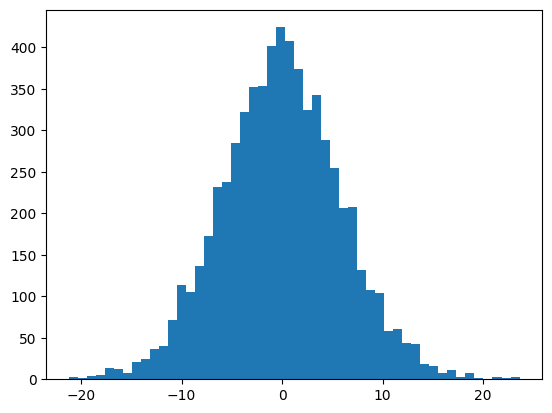

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50); # distribution of pre-activations

# with broad distribution of pre-activations, tanh will saturate for most neurons (as tanh squashes large inputs to -1 or 1)
# outputs of tanh close to -1 or 1 kills the gradients, so learning is very slow 
# backward pass for tanh: self.grad += (1 - t**2) * out.grad) ; high t -> low gradient (vanishing gradients)

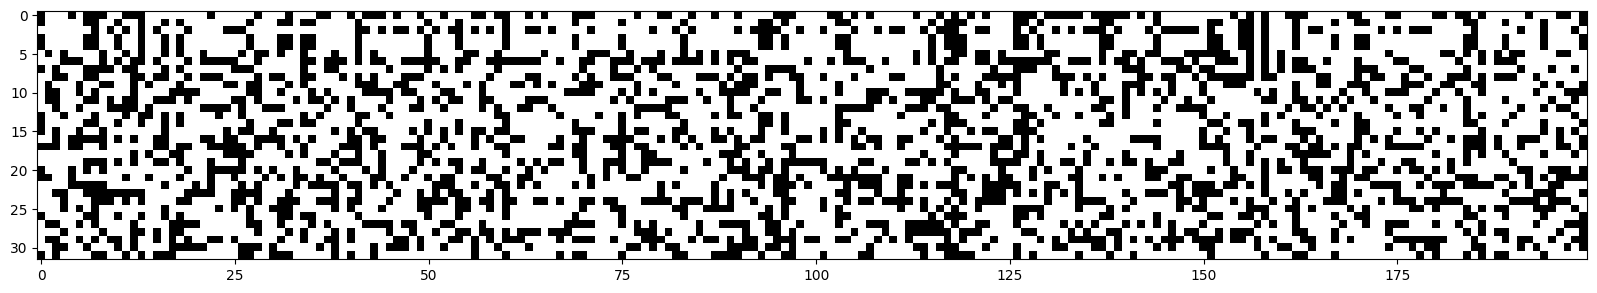

In [ ]:
# plot the neurons in h where the activation is saturated (abs value > 0.99); the white examples below

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# many are white, and backward gradient is limited at that layer  
# with a column entirely white, a neuron is "dead" and will never recover

# sigmoid, relu, etc. can all have dead neurons too
# leaky relu less likely; flat parts (low gradients) in activation functions can result in this

# mitigate in our model by squashing hpreact (low multiplier to W1 and b1)

h shape:  torch.Size([32, 200])


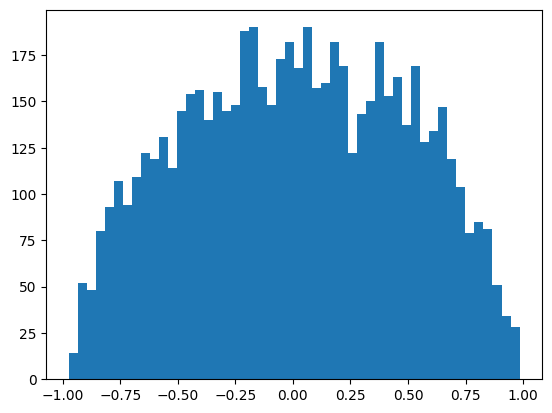

In [57]:
# recreate h for inspection

dim_embed = 10
hidden_layer_size = 200
context_length = 3

g = torch.Generator().manual_seed(978467474)
C = torch.randn((vocab_size, dim_embed),                            generator=g)
W1 = torch.randn((dim_embed * context_length, hidden_layer_size),   generator=g) * 0.1
b1 = torch.randn(hidden_layer_size,                                 generator=g) * 0.01 # non-zero for entropy
W2 = torch.randn((hidden_layer_size, vocab_size),                   generator=g) * 0.01 # initialize small but not 0, so that symmetry is broken
b2 = torch.randn(vocab_size,                                        generator=g) * 0 # initialize with zeros; between this and above, gives near uniform initial probabilities

parameters = [C, W1, b1, W2, b2] # all parameters of the model
for p in parameters:
    p.requires_grad = True

for _ in range(200000):

    # batch
    ix = torch.randint(0, Xtrain.shape[0], (32,))
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    # forward pass 
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    
    lr = 0.1 if _ < 100000 else 0.01

    # update
    with torch.no_grad():
        for p in parameters:
            p.add_(p.grad, alpha=-lr) 

    break # break after first step to inspect h

# h histogram
print("h shape: ", h.shape)

plt.hist(h.view(-1).tolist(), 50); # see h as a single vector -> list, plot values in histogram

# histogram shows most values are now between -1 and 1, so tanh is not saturated for most

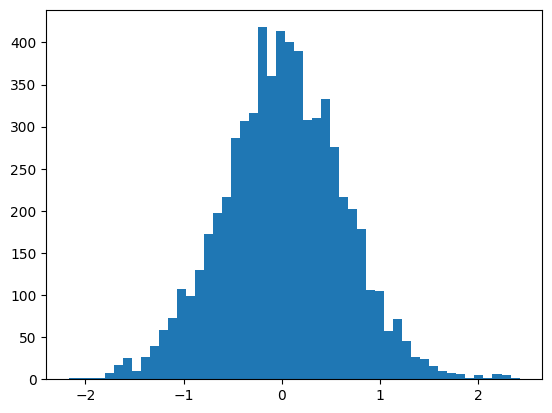

In [58]:
plt.hist(hpreact.view(-1).tolist(), 50); # distribution of pre-activations is now smaller


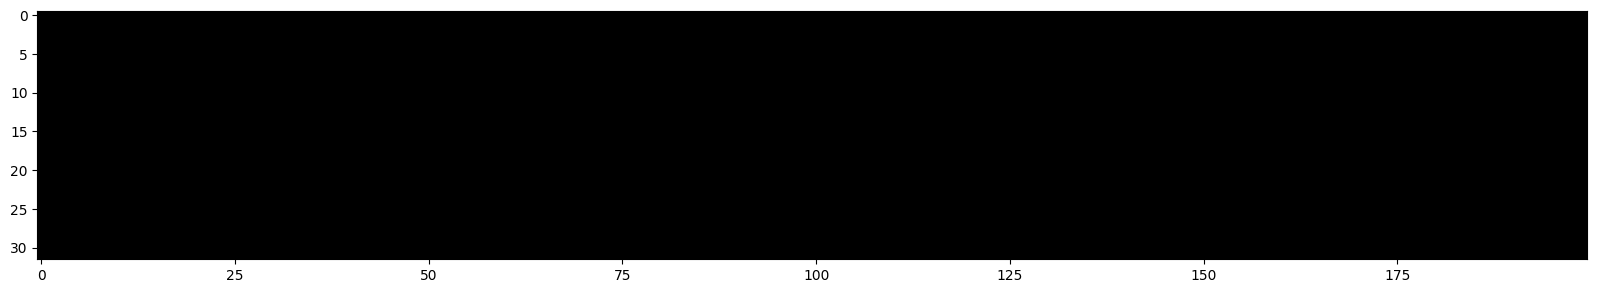

In [60]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # completely black columns: no gradients disappearing

### Kaiming initialization

Because nobody sets initialization for every layers' weights and biases scales by hand when the network gets deeper

Kaiming He: https://arxiv.org/abs/1502.01852

tensor(0.0050) tensor(1.0052)
tensor(0.0294) tensor(1.8986)


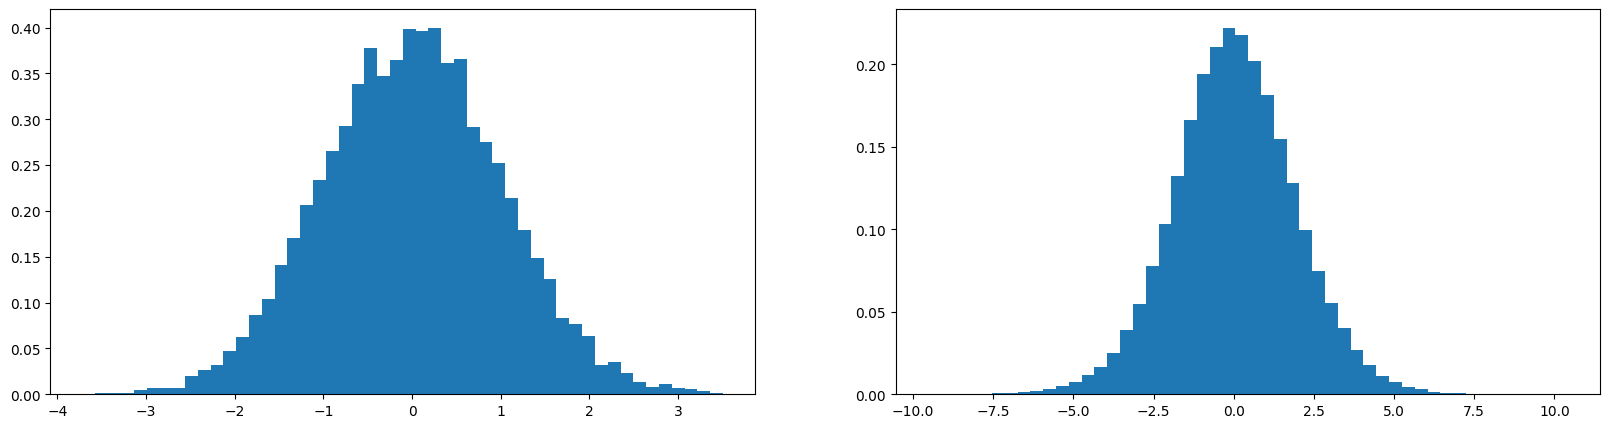

In [36]:
# variance grows through layers

x = torch.randn(1000, 10)
w = torch.rand(10, 200) # *5 scale up demonstrates the problem
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# demonstrates that the variance of y is larger than that of x due to the matrix multiplication with w
# the standard deviation grows; the Gaussian distribution is expanding outward
# this is undesirable; we want more uniform activations throughout the neural net 

tensor(-0.0016) tensor(1.0013)
tensor(-0.0029) tensor(0.9606)


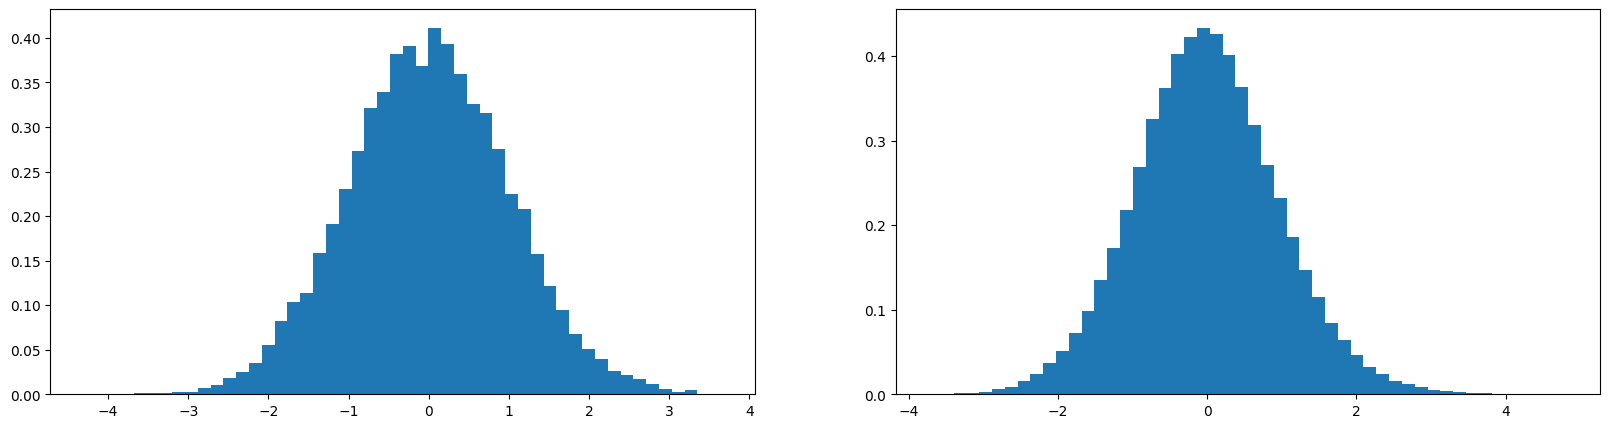

In [37]:
# calculating the init scale: kaiming init
# problem: matrix mult expands variance at each layer
# how do we initialize weights so that deep multilayer perceptrons have well-behaved activations through the layers?
# Kaiming He: https://arxiv.org/abs/1502.01852

x = torch.randn(1000, 10)
w = torch.rand(10, 200)*5 / (np.sqrt(10)*3)  # kaiming init scale: divide by sqrt of the fan-in (input size), multiply by gain factor
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

# now the output Gaussian y has the same standard deviation of 1 as x

# this is: torch.nn.init.kaiming_normal_(tensor,a=0,mode='fan_in',nonlinearlity='leaky_relu') (different gains for different activation functions)

In [38]:
# but this is still finicky and fragile
# modern practice: residual connections, batch or layer normalization, better optimizers like adam


#### BatchNorm

Modern approach: want hidden states to be roughly Gaussian; why not just normalize them to be Gaussian? 

Sergey Ioffe, Christian Szegedy: https://arxiv.org/abs/1502.03167

Paper: normalize hidden layer pre-activation by subtracting mean and dividing by standard deviation

To achieve good result: only want this at initialization

Scale and shift: scale by a gain, offset by a bias

Side effect: every training example in a batch is linked; turns into a regularizer, adds entropy/noise and helps prevent overfitting


### Convert to torch-style

Mostly straight copied from the [example](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb), since I have slowly worked through the implementation details above step by step along with the [video](https://youtu.be/P6sfmUTpUmc)

In [5]:
# Train a deeper network
# The classes here are the same style as nn.Module in PyTorch
# (run dataset initialization first)

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [24]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(42) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * context_length, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make output softmax less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1

  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # setting gain to 1 shows how further layers get squashed; 3 explodes gradients 

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [25]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtrain.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtrain[ix], Ytrain[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1:
    break # optionally limit to 1000 steps for debugging

      0/ 200000: 3.3313


#### Visualize histograms of the forward pass activations at the tanh layers


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 2.84%
layer 8 (      Tanh): mean +0.01, std 0.64, saturated: 2.38%
layer 11 (      Tanh): mean +0.00, std 0.63, saturated: 2.44%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.97%


Text(0.5, 1.0, 'activation distribution')

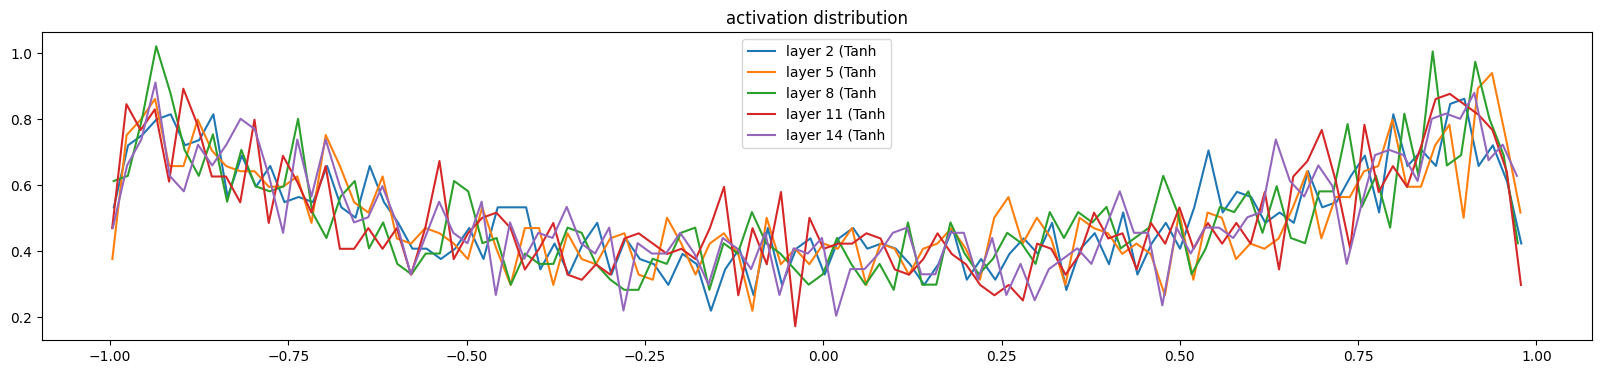

In [26]:
# visualize histograms
plt.figure(figsize=(20, 4)) 
legends = []
for i, layer in enumerate(layers[:-1]): # iterate over all layers; note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out # take the out tensor and then calculate stats (incl saturation)
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

# the histogram: each layer has a color; how many values in each tensor has a value in the x axis
# stabilizes in the middle layers thanks to the gain; without gain, std shrinks and saturation goes to 0, since further layers get squashed (tanh)
# with higher gain (e.g. 3), distribution widens and saturation is too high 

layer 2 (      Tanh): mean -0.000000, std 8.820127e-04
layer 5 (      Tanh): mean +0.000000, std 7.387857e-04
layer 8 (      Tanh): mean -0.000000, std 6.156137e-04
layer 11 (      Tanh): mean +0.000000, std 5.336498e-04
layer 14 (      Tanh): mean +0.000000, std 4.590911e-04


Text(0.5, 1.0, 'gradient distribution')

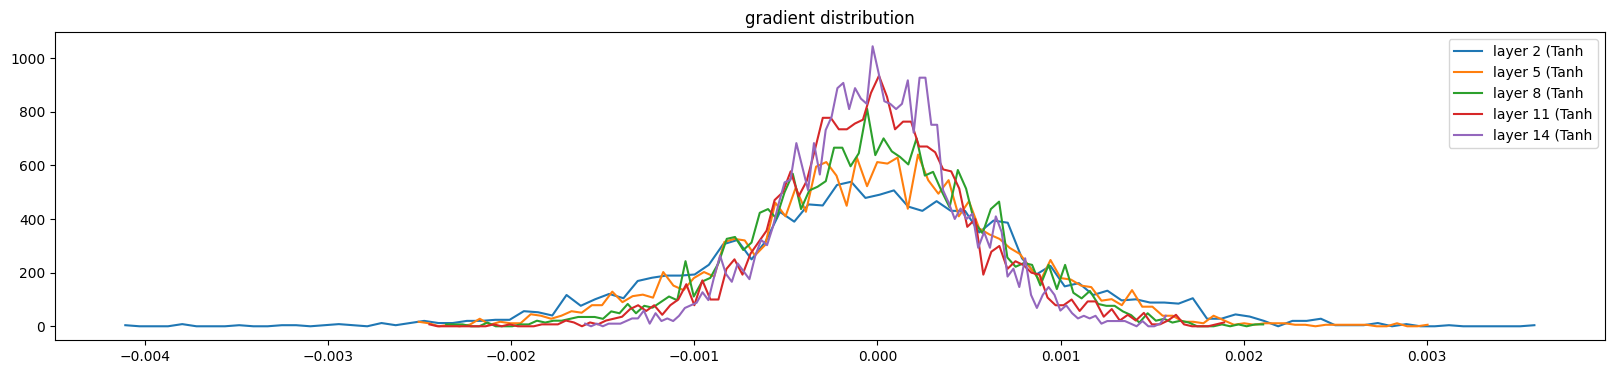

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) 
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

# visualizing the gradients
# looking for each layer to have roughly the same gradient; no shrinking or exploding as we go deeper
# if you remove tanh layers and graph the linear layers instead, shows how low gain -> shrinking gradients, high gain -> exploding gradients
# batchnorm also helps stabilize gradients; without it, the gain would be more finicky to set and the histograms would show more extreme shrinking or exploding gradients

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtrain, Ytrain),
    'val': (Xval, Yval),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

#### 